In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# time of the last run of the notebook
from datetime import datetime
print(f"Last run: {datetime.now()}")

Last run: 2024-03-30 16:41:11.242618


## Data exploration

In [3]:
df = pd.read_csv('data/wiki_movie_plots.csv')

In [4]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


### Genre processing

In [5]:
df.value_counts('Genre')

Genre
unknown                             6083
drama                               5964
comedy                              4379
horror                              1167
action                              1098
                                    ... 
family, crime, drama, romance          1
family, crime, drama                   1
animation, sports, comedy, drama       1
family, children's film                1
dramedy, fantasy                       1
Name: count, Length: 2265, dtype: int64

There are 6083 movies with unknown genre. Since the goal of the model is to predict the genre of a movie, we will remove these movies from the dataset. Some of the movies have multiple genres, so it makes the problem a multi-label classification problem. To handle this, we will create a new column for each genre and set it to 1 if the movie has that genre and 0 otherwise.

In [6]:
df = df[df['Genre'] != 'unknown'] # remove movies with unknown genre

Before splitting the genres I will remove special characters from the genre names.

In [7]:
# remove characters /-,&() from the genre names
df['Genre'] = df['Genre'].str.replace('-', ' ')
df['Genre'] = df['Genre'].str.replace('/', ' ')
df['Genre'] = df['Genre'].str.replace(',', ' ')
df['Genre'] = df['Genre'].str.replace('&', ' ')
df['Genre'] = df['Genre'].str.replace('(', '')
df['Genre'] = df['Genre'].str.replace(')', '')

In [8]:
df['Genre'] = df['Genre'].apply(lambda x: x.split(' ')) # split the genres

In [9]:
df['Genre'].value_counts()

Genre
[drama]                                                    5964
[comedy]                                                   4379
[horror]                                                   1167
[action]                                                   1098
[thriller]                                                  966
                                                           ... 
[drama, co, produced, with, the, national, film, board]       1
[historical, costume, drama]                                  1
[wartime, drama]                                              1
[kung, fu, film]                                              1
[horror, romantic, comedy]                                    1
Name: count, Length: 2135, dtype: int64

In [10]:
 # one-hot encode the genres
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_oh = df.join(pd.DataFrame(mlb.fit_transform(df.pop('Genre')),
                          columns=mlb.classes_,
                          index=df.index))

In [11]:
df_oh.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Wiki Page,Plot,,000,007,...,yash,years,yeh,yellow,yogesh,youth,yuen,zindagi,zombie,–
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,NaN,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,1906,From Leadville to Aspen: A Hold-Up in the Rockies,American,Francis J. Marion and Wallace McCutcheon,NaN,https://en.wikipedia.org/wiki/From_Leadville_t...,The film features a train traveling through th...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1906,Kathleen Mavourneen,American,Edwin S. Porter,NaN,https://en.wikipedia.org/wiki/Kathleen_Mavourn...,Irish villager Kathleen is a tenant of Captain...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now I will delete the most unpopular genres, since they are not very useful for the model. I will delete the genres that have less than 100 movies.

In [12]:
genre_count = df_oh.iloc[:, 7:].sum()
genre_count

           3723
000           1
007           2
1             1
16 mm         1
           ... 
youth        19
yuen          1
zindagi       1
zombie        5
–             1
Length: 702, dtype: int64

There is a column with white space, so I will remove it.

In [13]:
df_oh = df_oh.drop(columns=[''])

Now I will remove the unpopular genres, because they are not very useful for the model.

In [14]:
unpopular = genre_count[genre_count < 100]
df_oh_cleared = df_oh.drop(columns=unpopular.index)

In [15]:
# delete the movies that are left without genre
df_oh_cleared = df_oh_cleared[df_oh_cleared.iloc[:, 7:].sum(axis=1) > 0]

In [16]:
len(df_oh_cleared)

27802

I'm interested only in the plot of the movie and the genre, so I will remove the other columns.

In [17]:
df_oh_cleared = df_oh_cleared[['Plot'] + list(df_oh_cleared.columns[7:])]

In [18]:
df_oh_cleared.head()

,Plot,action,adventure,animated,animation,anime,arts,biography,comedy,crime,...,science,short,social,sports,spy,suspense,thriller,war,western,world
6,The film opens with two bandits breaking into ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,The film is about a family who move to the sub...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10,The Rarebit Fiend gorges on Welsh rarebit at a...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11,The film features a train traveling through th...,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
12,Irish villager Kathleen is a tenant of Captain...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Add plot that visualizes the distribution of the genres.

In [19]:
genre_count = df_oh_cleared.iloc[:, 1:].sum()
genre_count = genre_count.sort_values(ascending=False)
genre_count

drama         9397
comedy        7261
action        2448
romance       1939
thriller      1779
crime         1606
horror        1585
western        974
musical        947
adventure      866
romantic       680
family         633
war            609
science        575
fiction        563
film           548
fantasy        547
mystery        481
animated       418
fi             398
sci            398
noir           358
animation      349
biography      306
short          241
historical     224
social         223
suspense       162
anime          143
spy            143
sports         119
martial        110
arts           108
world          102
dtype: int64

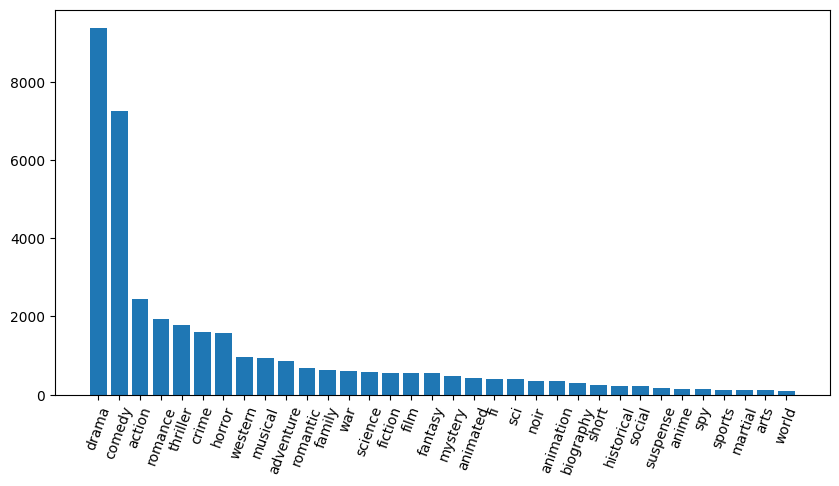

In [20]:
genre_count = df_oh_cleared.iloc[:, 1:].sum()
genre_count = genre_count.sort_values(ascending=False)
plt.figure(figsize=(10, 5))
plt.bar(genre_count.index, genre_count.values)
plt.xticks(rotation=70)
plt.show()

I can see that while removing the special characters from the genre names, I accidentally separated the `sci-fi` genre and `martial arts` into two genres. I will fix this.

In [21]:
df_oh_cleared['sci'] = df_oh_cleared['sci'] | df_oh_cleared['fi']
df_oh_cleared = df_oh_cleared.drop(columns=['fi'])
df_oh_cleared = df_oh_cleared.rename(columns={'sci': 'sci-fi'}) # rename the column back to sci-fi

In [22]:
df_oh_cleared['martial'] = df_oh_cleared['martial'] | df_oh_cleared['arts']
df_oh_cleared = df_oh_cleared.drop(columns=['arts'])
df_oh_cleared = df_oh_cleared.rename(columns={'martial': 'martial arts'}) # rename the column back to martial arts

I also see that `science` and `fiction` genres has almost the same nuber of movies but are separated. I will merge them into 1, if the movie has both genres. Since `sci-fi` refers to `science fiction` I will add leave only `science fiction` genre.

In [23]:
df_oh_cleared['science fiction'] = (df_oh_cleared['science'] & df_oh_cleared['fiction']) | df_oh_cleared['sci-fi']
df_oh_cleared = df_oh_cleared.drop(columns=['science', 'fiction', 'sci-fi'])

I also want to delete such columns as `anime`, `animation`, `short`, `film`, `animated` because they are not very useful for the model, since they do not refer to the plot of the movie. 

In [24]:
df_oh_cleared = df_oh_cleared.drop(columns=['anime', 'animation', 'short', 'film', 'animated'])

In [25]:
df_oh_cleared.head()

,Plot,action,adventure,biography,comedy,crime,drama,family,fantasy,historical,...,romantic,social,sports,spy,suspense,thriller,war,western,world,science fiction
6,The film opens with two bandits breaking into ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,The film is about a family who move to the sub...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,The Rarebit Fiend gorges on Welsh rarebit at a...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,The film features a train traveling through th...,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12,Irish villager Kathleen is a tenant of Captain...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Preprocessing the text

In [26]:
df_oh_cleared['Plot'] = df_oh_cleared['Plot'].str.lower() # convert to lowercase
df_oh_cleared['Plot'] = df_oh_cleared['Plot'].str.replace(r'[^a-zA-Z\s]', '') # remove special characters
df_oh_cleared['Plot'] = df_oh_cleared['Plot'].str.replace(r'\s+', ' ') # remove extra spaces

In [27]:
df_oh_cleared.head()

,Plot,action,adventure,biography,comedy,crime,drama,family,fantasy,historical,...,romantic,social,sports,spy,suspense,thriller,war,western,world,science fiction
6,the film opens with two bandits breaking into ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,the film is about a family who move to the sub...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,the rarebit fiend gorges on welsh rarebit at a...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,the film features a train traveling through th...,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12,irish villager kathleen is a tenant of captain...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train-test split

I will split the data into training and testing sets. I will use 80% of the data for training and 20% for testing.

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X = df_oh_cleared['Plot']
y = df_oh_cleared.iloc[:, 1:]

In [30]:
y

,action,adventure,biography,comedy,crime,drama,family,fantasy,historical,horror,...,romantic,social,sports,spy,suspense,thriller,war,western,world,science fiction
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34877,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34882,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34883,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34884,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22241,), (5561,), (22241, 25), (5561, 25))

## Modeling

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier

### OneVsRestClassifier with logistic regression
First I will try to use logistic regression with tf-idf vectorizer to create classifiers for each class. I will use the top 10000 features.

In [34]:
tfidf = TfidfVectorizer(max_features=10000)
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model_0 = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf)
])

In [35]:
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=10000)),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000)))])

In [36]:
y_pred = model_0.predict(X_test)

In [37]:
accuracy_score(y_test, y_pred)

0.23610861355871246

In [38]:
print(classification_report(y_test, y_pred, target_names=y.columns))

                 precision    recall  f1-score   support

         action       0.74      0.14      0.24       499
      adventure       0.85      0.06      0.12       174
      biography       0.00      0.00      0.00        63
         comedy       0.73      0.35      0.48      1473
          crime       0.58      0.04      0.08       312
          drama       0.68      0.41      0.51      1877
         family       0.00      0.00      0.00       116
        fantasy       0.50      0.01      0.02       109
     historical       0.00      0.00      0.00        38
         horror       0.89      0.19      0.31       337
   martial arts       0.00      0.00      0.00        27
        musical       0.86      0.03      0.06       193
        mystery       1.00      0.01      0.02        96
           noir       0.00      0.00      0.00        59
        romance       0.67      0.12      0.21       391
       romantic       0.00      0.00      0.00       123
         social       0.00    

/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

Based on the classification report, I can see that the model has problems with predicting the minority classes. I will try to use a neural network with an embedding layer to improve the results.

### Sequential model with embedding

In [39]:
import tensorflow as tf
from tensorflow.keras import layers

Since I already have on-hot encoded labels, before creating the model, I will create a TextVectorization layer that will convert the text to a sequence of integers. I will use the top 10000 tokens and the output sequence length of 200.

In [40]:
X_train_list = X_train.to_list()
X_test_list = X_test.to_list()

In [41]:
# Find optimal number for output_sequence_length
sent_lens = [len(sentence.split()) for sentence in X_train_list]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

386.7983903601457

In [42]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

918

I will also find the vocabulary size and use the 95th percentile of the vocabulary size for my vectorization layer.

In [43]:
from collections import Counter
import re

# Flatten the list of texts if your dataset is structured differently
all_texts = ' '.join(X_train_list)

# Simple tokenization based on whitespace; you might need a more sophisticated approach
tokens = re.findall(r'\b\w+\b', all_texts.lower())

# Count unique tokens
token_counts = Counter(tokens)
vocab_size = len(token_counts)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 108026


In [44]:
total_occurrences = sum(token_counts.values())
cumulative_occurrences = 0
vocab_size_95 = 0

# Sort tokens by frequency
sorted_tokens = token_counts.most_common()

# Find the number of tokens that make up at least 95% of total occurrences
for token, count in sorted_tokens:
    cumulative_occurrences += count
    vocab_size_95 += 1
    if cumulative_occurrences >= total_occurrences * 0.95:
        break

print(f"Vocabulary size covering 95% of token occurrences: {vocab_size_95}")

Vocabulary size covering 95% of token occurrences: 17294


In [45]:
# Adding a buffer for OOV tokens
buffer_size = 1000  # or any other number based on your assessment
adj_vocab_size = vocab_size_95 + buffer_size

print(f"Adjusted vocabulary size with buffer for OOV tokens: {adj_vocab_size}")


Adjusted vocabulary size with buffer for OOV tokens: 18294


In [46]:
# Create the TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=adj_vocab_size, output_sequence_length=output_seq_len)
# Adapt it to the training data
vectorize_layer.adapt(X_train.to_numpy())

In [47]:
model_1 = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=adj_vocab_size + 1, output_dim=128),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(y_train.shape[1], activation='sigmoid')
])

In [48]:
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
model_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2602 - loss: 0.1997 - val_accuracy: 0.2701 - val_loss: 0.1541
Epoch 2/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2690 - loss: 0.1551 - val_accuracy: 0.2857 - val_loss: 0.1503
Epoch 3/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2918 - loss: 0.1508 - val_accuracy: 0.3079 - val_loss: 0.1469
Epoch 4/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3266 - loss: 0.1458 - val_accuracy: 0.3573 - val_loss: 0.1408
Epoch 5/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3666 - loss: 0.1403 - val_accuracy: 0.3737 - val_loss: 0.1369
Epoch 6/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4050 - loss: 0.1339 - val_accuracy: 0.3659 - val_loss: 0.1356
Epoch 7/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4174 - loss: 0.1296 - val_accuracy: 0.3915 - val_loss: 0.1322
Epoch 8/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4473 - loss: 0.1239 - val_accur

In [50]:
y_pred = model_1.predict(X_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [51]:
y_pred = (y_pred > 0.5).astype(int)
y_pred[:5]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]])

In [52]:
# evaluate the model
accuracy_score(y_test, y_pred) 

0.2853803272792663

In [53]:
# print the classification report
print(classification_report(y_test, y_pred, target_names=y.columns))

                 precision    recall  f1-score   support

         action       0.58      0.27      0.37       499
      adventure       0.50      0.01      0.02       174
      biography       0.00      0.00      0.00        63
         comedy       0.54      0.66      0.59      1473
          crime       0.50      0.02      0.03       312
          drama       0.62      0.46      0.53      1877
         family       0.00      0.00      0.00       116
        fantasy       0.31      0.09      0.14       109
     historical       0.00      0.00      0.00        38
         horror       0.77      0.43      0.55       337
   martial arts       0.00      0.00      0.00        27
        musical       0.44      0.02      0.04       193
        mystery       0.50      0.01      0.02        96
           noir       1.00      0.02      0.03        59
        romance       0.51      0.24      0.33       391
       romantic       0.00      0.00      0.00       123
         social       0.00    

/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

The performance of model is worse than the logistic regression model. I will try to use oversampling to improve the results.

### Oversampling

The model with the embedding layer performs better than the logistic regression model. However, it still has problems with predicting the minority classes. I will try to use the oversampling technique to improve the results. First I will create duplicate samples for the minority classes (applied to the split data to avoid data leakage).

In [54]:
# find minority classes (less than 1000 samples)
genre_count = df_oh_cleared.iloc[:, 1:].sum()
minority_classes = genre_count[genre_count < 1000].index
minority_classes

Index(['adventure', 'biography', 'family', 'fantasy', 'historical',
       'martial arts', 'musical', 'mystery', 'noir', 'romantic', 'social',
       'sports', 'spy', 'suspense', 'war', 'western', 'world',
       'science fiction'],
      dtype='object')

In [55]:
X = df_oh_cleared['Plot']
y = df_oh_cleared.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
minority_indices = y_train[y_train[minority_classes].sum(axis=1) > 0].index

In [57]:
X_train.shape, y_train.shape

((22241,), (22241, 25))

#### Duplicating samples

I want to create duplicate samples for the minority classes depending on the number of samples in this class. I will calculate the duplication factor for each class, so that the number of samples in each class is at least 1000.

In [58]:
genre_counts_train = y_train.sum(axis=0)
genre_counts_train.sort_values()[:5]

world            82
martial arts     83
sports          100
spy             118
suspense        131
dtype: int64

In [59]:
def duplication_factor(num_samples):
    return int(np.ceil(1000 / num_samples))

Before oversampling, I want to create not just duplicates, but modify them. For this I will create a function that will apply transformations to the data. I will use the following transformations:
- change words to synonyms (using WordNet) with a probability of 0.3
- use back translation (translate the text to another language and then back to the original language)


#### Synonym replacement

In [60]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexeyks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [61]:
from itertools import chain
from nltk.corpus import wordnet
import random

from itertools import chain
from nltk.corpus import wordnet
import random

def synonym_replacement(sentence, rep_prob=0.2):
    words = sentence.split()
    new_words = []
    for word in words:
        if isinstance(word, str) and random.uniform(0, 1) <= rep_prob:
            synonyms = set(chain.from_iterable([syn.lemma_names() for syn in wordnet.synsets(word)]))
            if synonyms:
                new_words.append(random.choice(list(synonyms)))
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return ' '.join(new_words)

In [62]:
sentence = 'The movie is about a young man who decided to become a musician at 30 years.'
translated_sentence = synonym_replacement(sentence)
translated_sentence

'The movie is about a young man who decided to become a musician atomic_number_85 30 years.'

#### Back translation

For translation, I will use transformers library. I will use HuggingFace's pipeline for translation. I will translate the text to French and then back to English.

In [63]:
from transformers import pipeline

# Initialize translation pipelines globally
translate_to_intermediate_pipeline = pipeline("translation", model=f"Helsinki-NLP/opus-mt-en-fr")
translate_back_to_src_pipeline = pipeline("translation", model=f"Helsinki-NLP/opus-mt-fr-en")

# Define back translation function
def back_translate(text, translate_to_intermediate, translate_back_to_src):
    # Translate to the intermediate language
    translation = translate_to_intermediate(text)
    intermediate_text = translation[0]['translation_text']
    
    # Translate back to the source language
    back_translation = translate_back_to_src(intermediate_text)
    src_text = back_translation[0]['translation_text']
    
    return src_text



All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-fr.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-fr-en.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


In [64]:
back_translate(sentence, translate_to_intermediate_pipeline, translate_back_to_src_pipeline)

'The film speaks of a young man who decided to become a musician at the age of 30.'

In [65]:
X_train.shape, y_train.shape

((22241,), (22241, 25))

The specified maximum sequence length for the translation model is 512. Some of the plots are longer than this, so I will use Split-Translate-Combine approach, where I will split the text into smaller parts, translate them and then combine them back.

In [66]:
def split_text(text, max_length=512):
    """
    Splits a text into chunks of `max_length`.
    """
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0

    for word in words:
        if current_length + len(word) + 1 <= max_length:  # +1 for space
            current_chunk.append(word)
            current_length += len(word) + 1
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [word]
            current_length = len(word) + 1

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

def combine_chunks(chunks):
    """
    Combines translated chunks back into a full text.
    """
    return ' '.join(chunks)


def back_translate_chunks(chunks, src_lang="en", intermediate_lang="fr"):
    """
    Applies back translation to a list of text chunks.
    Adjust this function to utilize your back_translation implementation.
    """
    translated_chunks = [back_translate(chunk, src_lang, intermediate_lang) for chunk in chunks]
    return translated_chunks

def process_long_text(text, src_lang="en", intermediate_lang="fr"):
    """
    Processes long texts by splitting, back translating each chunk, and then combining.
    """
    chunks = split_text(text)  # Use the refined split function
    translated_chunks = [back_translate(chunk, translate_to_intermediate_pipeline, translate_back_to_src_pipeline) for chunk in chunks] 
    translated_text = combine_chunks(translated_chunks)  # Use the refined combine function
    return translated_text



In [67]:
# Example
long_text = df_oh_cleared['Plot'][18649]
processed_text = process_long_text(long_text)
processed_text

'In a barrack room at a combat training field in England, a platoon of conscripts complain of blisters and are eager to take action with the enemy. Sergeant Jack Watson tells them that they need a little more to succeed in the fight, which he illustrates with a history of his experience in the western desert campaign[1]. His story is then shown in flashback. Lieutenant Crawford, Sergeant Watson and the seven men under their command travel in the Libyan desert in a Allied convoy, when their truck becomes stuck in the sand and the convoy moves without them. while they work to free themselves, they are attacked by German planes, wounding Crawford and Johnson and setting fire to the truck. slam on foot and carry the wounded, they fight through a sandstorm until they cross an abandoned cabin. Lieutenant Crawford orders them to stand there until the aid arrives, but then dies. with only a limited supply of ammunition and their own minds to help them. They are then besieged by the Italian tro

In [68]:
df_oh_cleared['Plot'][18649]

'in a barrack room at a battle training ground in england, a platoon of conscripts are complaining about blisters and are impatient to get into action with the enemy. sergeant jack watson tells them that they need a little bit extra to be successful in combat, which he illustrates with a story from his experience in the western desert campaign.[1]\r\nhis story is then shown in flashback. lieutenant crawford, sergeant watson and the seven men under their command are travelling through the libyan desert in an allied convoy, when their lorry becomes stuck in the sand and the convoy moves on without them. as they work to free themselves, they are attacked by german aircraft, injuring crawford and johnson and setting fire to the lorry. setting off on foot and carrying the wounded, they struggle through a sandstorm until they come across a derelict hut. lieutenant crawford orders them to hold out there until help arrives but then dies. with only a limited supply of ammunition and their own w

I can see that the function works correctly. However, translation of one plot took almost a minute. 

In [69]:
# calculate the distribution of length of the plots (words)
df_oh_cleared['Plot'].apply(lambda x: len(x.split())).describe()

count    27802.000000
mean       386.423027
std        312.956577
min          2.000000
25%        128.000000
50%        311.000000
75%        602.000000
max       5272.000000
Name: Plot, dtype: float64


##### Translation rejection
I can see that plots are quite long (up to 5000 words). For my oversampling I decided to use only synonym replacement in order to save time. The part with back translation is commented out. However It works, and if you have computational resources, you can use it by uncommenting the code.

#### Applying transformations

In [70]:
# Find minority classes (less than 1000 samples)
l = []
for genre, num_samples in genre_counts_train.items():
    if num_samples < 1000:  # Only duplicate samples for minority classes
        factor = duplication_factor(num_samples) 
        l.append((genre, num_samples, factor))
l

[('adventure', 692, 2),
 ('biography', 243, 5),
 ('family', 517, 2),
 ('fantasy', 438, 3),
 ('historical', 186, 6),
 ('martial arts', 83, 13),
 ('musical', 754, 2),
 ('mystery', 385, 3),
 ('noir', 299, 4),
 ('romantic', 557, 2),
 ('social', 178, 6),
 ('sports', 100, 10),
 ('spy', 118, 9),
 ('suspense', 131, 8),
 ('war', 500, 2),
 ('western', 756, 2),
 ('world', 82, 13),
 ('science fiction', 776, 2)]

In [71]:
# combine X_train and y_train for easier manipulation
train_data = pd.concat([X_train, y_train], axis=1)

# create placeholder for oversampled data
oversampled_data = pd.DataFrame(columns=train_data.columns)

for genre, num_samples in genre_counts_train.items():
    if num_samples < 1000:  # Only duplicate samples for minority classes
        factor = duplication_factor(num_samples) 
    
        # Find indices of movies belonging to the current genre
        genre_indices = y_train[y_train[genre] == 1].index
        temp_data = train_data.loc[genre_indices].copy()
        for _ in range(factor - 1):
            # Make a copy with transformations 
            transformed_data = temp_data.copy()
            transformed_data['Plot'] = transformed_data['Plot'].apply(lambda x: synonym_replacement(x))
            
            
            # Apply back translation depending on the length of the text
            # if len(transformed_data['Plot'].iloc[0]) > 512:
            #     transformed_data['Plot'] = transformed_data['Plot'].apply(lambda x: process_long_text(x))
            # else:
            #     transformed_data['Plot'] = transformed_data['Plot'].apply(lambda x: back_translate(x, translate_to_intermediate_pipeline, translate_back_to_src_pipeline))
                
                
            # make the text lowercase
            transformed_data['Plot'] = transformed_data['Plot'].str.lower()
            oversampled_data = pd.concat([oversampled_data, transformed_data], ignore_index=True)

In [72]:
# check the shape of the oversampled data
oversampled_data.shape, train_data.shape

((14628, 26), (22241, 26))

In [73]:
from sklearn.utils import shuffle

# # Combine all oversampled data together
# oversampled_data = pd.concat(oversampled_data, ignore_index=True)

# Add the original data to ensure it's represented in the oversampled dataset
oversampled_data = pd.concat([oversampled_data, train_data], ignore_index=True)

# Shuffle the dataset to mix original and oversampled data
oversampled_data = shuffle(oversampled_data, random_state=42)

# Split the oversampled data back into features and labels
X_train_oversampled = oversampled_data['Plot']
y_train_oversampled = oversampled_data[y_train.columns]

In [74]:
X_train_oversampled.shape, y_train_oversampled.shape

((36869,), (36869, 25))

In [75]:
y_train_oversampled.sum().sort_values()[:5]

sports          1029
suspense        1056
martial arts    1104
social          1115
spy             1143
dtype: object

In [76]:
# convert the labels to numpy array, without this the model will not fit
y_train_oversampled_np = np.array(y_train_oversampled).astype('float32')

### Model 1 with oversampling

I will replicate the model with the embedding layer and train it on the oversampled data.

In [77]:
# Create the TextVectorization layer
vectorize_layer = layers.TextVectorization(max_tokens=adj_vocab_size, output_sequence_length=output_seq_len)
# Adapt it to the training oversampled data
vectorize_layer.adapt(np.array(X_train_oversampled, dtype=str))

In [78]:
model_2 = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=adj_vocab_size + 1, output_dim=128),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(y_train_oversampled.shape[1], activation='sigmoid')
])

In [79]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
model_2.fit(X_train_oversampled, y_train_oversampled_np, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.2041 - loss: 0.2236 - val_accuracy: 0.2845 - val_loss: 0.1572
Epoch 2/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2569 - loss: 0.1859 - val_accuracy: 0.3244 - val_loss: 0.1481
Epoch 3/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3220 - loss: 0.1626 - val_accuracy: 0.3595 - val_loss: 0.1395
Epoch 4/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3819 - loss: 0.1418 - val_accuracy: 0.3888 - val_loss: 0.1369
Epoch 5/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4417 - loss: 0.1255 - val_accuracy: 0.4586 - val_loss: 0.1316
Epoch 6/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4896 - loss: 0.1118 - val_accuracy: 0.4145 - val_loss: 0.1266
Epoch 7/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5229 - loss: 0.1017 - val_accuracy: 0.4573 - val_loss: 0.1286
Epoch 8/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5499 - loss: 0

In [81]:
y_pred = model_2.predict(X_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [82]:
y_pred = (y_pred > 0.5).astype(int)

In [83]:
accuracy_score(y_test, y_pred)

0.28304261823413057

In [84]:
print(classification_report(y_test, y_pred, target_names=y.columns))

                 precision    recall  f1-score   support

         action       0.61      0.23      0.33       499
      adventure       0.33      0.16      0.22       174
      biography       1.00      0.05      0.09        63
         comedy       0.73      0.18      0.29      1473
          crime       0.49      0.08      0.13       312
          drama       0.42      0.91      0.57      1877
         family       0.17      0.04      0.07       116
        fantasy       0.38      0.21      0.27       109
     historical       0.17      0.42      0.24        38
         horror       0.73      0.47      0.57       337
   martial arts       0.80      0.15      0.25        27
        musical       0.56      0.25      0.35       193
        mystery       0.35      0.25      0.29        96
           noir       0.30      0.05      0.09        59
        romance       0.43      0.35      0.39       391
       romantic       0.10      0.01      0.02       123
         social       0.18    

/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

The accuracy is higher than the previous models, but it is still not very high. I will try to use LSTM model to improve the results.

### LSTM model
At this point I want to try to make more complex model using LSTM layer. I will use Sequential Keras API to create the model. Training the model will take a lot of time, so I will use only 10% of the data for training.

In [ ]:
X_train_10, _, y_train_10, _ = train_test_split(X_train_oversampled, y_train_oversampled, test_size=0.9, random_state=42)

X_train_10.shape, y_train_10.shape

In [192]:
X_test_10, _, y_test_10, _ = train_test_split(X_test, y_test, test_size=0.9, random_state=42)

X_test_10.shape, y_test_10.shape

((556,), (556, 25))

In [ ]:
y_train_10_np = np.array(y_train_10).astype('float32')
y_test_np = np.array(y_test).astype('float32')
y_train_10_np.shape, y_test_np.shape

In [198]:
y_test_10_np = np.array(y_test_10).astype('float32')
y_test_10_np.shape

(556, 25)

In [ ]:
# Create the TextVectorization layer
vectorize_layer = layers.TextVectorization(max_tokens=adj_vocab_size, output_sequence_length=output_seq_len)
# Adapt it to the training oversampled data
vectorize_layer.adapt(np.array(X_train_10, dtype=str))

In [159]:
from tensorflow.keras import layers, Model, Input

# use sequential API
model_3 = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=adj_vocab_size + 1, output_dim=128),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dense(128, activation='relu'),
    layers.Dense(y_train_oversampled.shape[1], activation='sigmoid')
])

In [160]:
# model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 918)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [161]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [164]:
model_3.fit(X_train_10, y_train_10_np, epochs=5, batch_size=32, validation_data=(X_test, y_test_np))

Epoch 1/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.1569 - loss: 0.3134 - val_accuracy: 0.2692 - val_loss: 0.1655
Epoch 2/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.2259 - loss: 0.1984 - val_accuracy: 0.2687 - val_loss: 0.1630
Epoch 3/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.2320 - loss: 0.1932 - val_accuracy: 0.2708 - val_loss: 0.1609
Epoch 4/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.3225 - loss: 0.1710 - val_accuracy: 0.2910 - val_loss: 0.1612
Epoch 5/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.4545 - loss: 0.1386 - val_accuracy: 0.2728 - val_loss: 0.1723


In [165]:
y_pred = model_3.predict(X_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 64s 366ms/step


In [166]:
y_pred = (y_pred > 0.5).astype(int)

In [167]:
accuracy_score(y_test, y_pred)

0.13900377629922675

In [168]:
print(classification_report(y_test, y_pred, target_names=y.columns))

                 precision    recall  f1-score   support

         action       0.50      0.00      0.00       499
      adventure       0.00      0.00      0.00       174
      biography       0.00      0.00      0.00        63
         comedy       0.40      0.26      0.32      1473
          crime       0.00      0.00      0.00       312
          drama       0.42      0.31      0.36      1877
         family       0.00      0.00      0.00       116
        fantasy       0.00      0.00      0.00       109
     historical       0.05      0.03      0.04        38
         horror       0.00      0.00      0.00       337
   martial arts       0.00      0.00      0.00        27
        musical       0.00      0.00      0.00       193
        mystery       0.00      0.00      0.00        96
           noir       0.00      0.00      0.00        59
        romance       0.56      0.01      0.03       391
       romantic       0.00      0.00      0.00       123
         social       0.00    

/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

Model 3 has worse performance than previous models, I suppose the model architecture might not be the best for our goals. Another reason of poor performance - training only on a small subset of data, because of restricted computational resources.

### Transfer learning. BERT

At the end I want to try to use BERT model for text classification. I will use the transformers library for this purpose.

In [185]:
from transformers import BertTokenizer, TFBertModel

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert = TFBertModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [171]:
# Tokenize the text
def encode_text(sentences, tokenizer, max_length=512):
    input_ids = []
    attention_masks = []
    
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,                      # Sentence to encode
            add_special_tokens=True,   # Add '[CLS]' and '[SEP]'
            max_length=max_length,     # Pad or truncate
            truncation=True,
            padding='max_length',
            return_attention_mask=True,# Construct attention masks
            return_tensors='tf',       # Return TensorFlow tensors
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert lists to tensors
    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    return input_ids, attention_masks

In [193]:
X_train_encoded, X_train_attention = encode_text(X_train_10, tokenizer)
X_test_encoded, X_test_attention = encode_text(X_test_10, tokenizer)

**Building the model**

In [195]:
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Input, Layer, Dense, Dropout

class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        return self.bert(input_ids, attention_mask=attention_mask)[1]  # pooler_output

# Instantiate BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define model inputs
input_ids = Input(shape=(512,), dtype='int32', name='input_ids')
attention_masks = Input(shape=(512,), dtype='int32', name='attention_masks')

# Use the custom BertLayer
bert_output = BertLayer(bert_model)([input_ids, attention_masks])

# Additional layers
dropout = Dropout(0.2)(bert_output)
output = Dense(y_train_oversampled.shape[1], activation='sigmoid')(dropout)

# Construct and compile the model
model_bert = Model(inputs=[input_ids, attention_masks], outputs=output)
model_bert.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [196]:
model_bert.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [189]:
model_bert.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_masks     │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_1        │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_masks[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 768)       │          0 │ bert_layer_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 25)        │     19,225 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,225 (75.10 KB)

 Trainable params: 19,225 (75.10 KB)

 Non-trainable params: 0 (0.00 B)

In [200]:
model_bert.fit([X_train_encoded, X_train_attention], y_train_10_np, epochs=3, batch_size=64, validation_data=([X_test_encoded, X_test_attention], y_test_10_np))

Epoch 1/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 1274s 22s/step - accuracy: 0.1175 - loss: 0.3394 - val_accuracy: 0.2698 - val_loss: 0.1650
Epoch 2/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 1286s 22s/step - accuracy: 0.2291 - loss: 0.1980 - val_accuracy: 0.2806 - val_loss: 0.1607
Epoch 3/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 1189s 21s/step - accuracy: 0.2482 - loss: 0.1933 - val_accuracy: 0.2968 - val_loss: 0.1567


In [201]:
y_pred = model_bert.predict([X_test_encoded, X_test_attention])

18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step


In [202]:
y_pred = (y_pred > 0.5).astype(int)

In [205]:
accuracy_score(y_test_10_np, y_pred)

0.02158273381294964

In [207]:
print(classification_report(y_test_10, y_pred, target_names=y.columns))

                 precision    recall  f1-score   support

         action       1.00      0.02      0.05        42
      adventure       0.00      0.00      0.00        19
      biography       0.00      0.00      0.00         9
         comedy       0.00      0.00      0.00       162
          crime       0.00      0.00      0.00        27
          drama       0.00      0.00      0.00       187
         family       0.00      0.00      0.00        13
        fantasy       0.00      0.00      0.00         9
     historical       0.00      0.00      0.00         5
         horror       0.00      0.00      0.00        31
   martial arts       0.00      0.00      0.00         3
        musical       0.00      0.00      0.00        15
        mystery       0.00      0.00      0.00        11
           noir       0.00      0.00      0.00         9
        romance       1.00      0.03      0.05        39
       romantic       0.00      0.00      0.00        14
         social       0.00    

/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexeyks/PycharmProjects/moviesml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

The BERT model has the worst performance. The reasons might be the same as the ones that lead to poor performance of the third model: wrong architecture, not enough data.

## Conclusion
This project shows, that in machine learning not everything goes as planned. There are many reasons why something could work wrong or not in the way you wanted to. That is why I will try to do more experiments in the future. Probably later I will come back to this project, in order to try another models and solutions to the stated problem. 